In [ ]:
import os
import tensorflow as tf
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/Dewni Hasara/dataset'
os.listdir(data_dir)

['Cs', 'Ac', 'Sc', 'Cu', 'Cc', 'As', 'Ns', 'Ci', 'St', 'Ct', 'Cb']

In [ ]:
import random
import shutil

In [ ]:
# Creates 3 folders for Train, Test and Validation data
def split_dir_to_train_test_val(directory = "/content/drive/My Drive/Dewni Hasara/dataset/", train_size = 0.7, test_size = 0.2, val_size = 0.1):
  # Set random seed
  rng = random.Random(42)

  for root, folders, files in os.walk(directory):
    for folder in folders:
      # Create list of the files
      list_of_files = []
      for file_name in os.listdir(root+folder+"/"):
        list_of_files.append(file_name)

      #  Shuffle the list
      rng.shuffle(list_of_files)

      # Create lists of files
      train_files = list_of_files[:int(len(list_of_files)*train_size)]
      test_files = list_of_files[int(len(list_of_files)*train_size) : int(len(list_of_files)*(train_size+test_size))]
      val_files = list_of_files[int(len(list_of_files)*(train_size+test_size)):]

      # Create folders and files for train data
      for one_file in train_files:

        # Copy  files
        dest_dir = "files/train/"+folder+"/"
        os.makedirs(dest_dir, exist_ok=True)

        shutil.copy2(src=(root+folder+"/"+one_file),
                    dst=(dest_dir+one_file))
      print(f"Folder {folder}. Train data copied. {len(train_files)} files")

      # Create folders and files for test data
      for one_file in test_files:
        # Copy  files
        dest_dir = "files/test/"+folder+"/"
        os.makedirs(dest_dir, exist_ok=True)

        shutil.copy2(src=(root+folder+"/"+one_file),
                    dst=(dest_dir+one_file))
      print(f"Folder {folder}. Test data copied. {len(test_files)} files")

      # Create folders and files for validation data
      for one_file in val_files:

        # Copy  files
        dest_dir = "files/validation/"+folder+"/"
        os.makedirs(dest_dir, exist_ok=True)

        shutil.copy2(src=(root+folder+"/"+one_file),
                    dst=(dest_dir+one_file))
      print(f"Folder {folder}. Validation data copied. {len(val_files)} files")

In [ ]:
import pathlib
import numpy as np

In [ ]:
# Get the classnames from train folder for example
def get_class_names_from_folder(directory):
  data_dir = pathlib.Path(directory)
  class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class names
  print(class_names)
  return class_names

In [ ]:
# Split images dir to train, test and validation
split_dir_to_train_test_val()

Folder Cs. Train data copied. 200 files
Folder Cs. Test data copied. 58 files
Folder Cs. Validation data copied. 29 files
Folder Ac. Train data copied. 154 files
Folder Ac. Test data copied. 44 files
Folder Ac. Validation data copied. 23 files
Folder Sc. Train data copied. 237 files
Folder Sc. Test data copied. 68 files
Folder Sc. Validation data copied. 35 files
Folder Cu. Train data copied. 127 files
Folder Cu. Test data copied. 36 files
Folder Cu. Validation data copied. 19 files
Folder Cc. Train data copied. 187 files
Folder Cc. Test data copied. 54 files
Folder Cc. Validation data copied. 27 files
Folder As. Train data copied. 131 files
Folder As. Test data copied. 38 files
Folder As. Validation data copied. 19 files
Folder Ns. Train data copied. 191 files
Folder Ns. Test data copied. 55 files
Folder Ns. Validation data copied. 28 files
Folder Ci. Train data copied. 97 files
Folder Ci. Test data copied. 28 files
Folder Ci. Validation data copied. 14 files
Folder St. Train data cop

In [ ]:
class_names = get_class_names_from_folder(directory="files/train/")

['Ac' 'As' 'Cb' 'Cc' 'Ci' 'Cs' 'Ct' 'Cu' 'Ns' 'Sc' 'St']


In [ ]:
len(class_names)

11

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

(400, 400, 3)


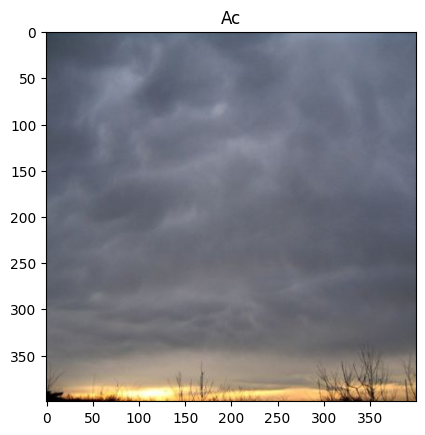

In [ ]:
# Visualises random image from exact directory
def visualize_random_image(target_dir, target_class):
  image_dir = target_dir + target_class
  random_image = random.sample(os.listdir(image_dir), 1)

  img = mpimg.imread(image_dir + "/" + random_image[0])
  print(img.shape)
  plt.imshow(img)
  plt.title(target_class)

visualize_random_image("files/test/", "Ac")

In [ ]:
# data pre processing and data augmentation
# used rescaling for now

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(directory="files/train",
                                               target_size=(400, 400),
                                               batch_size=32,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(directory="files/test",
                                               target_size=(400, 400),
                                               batch_size=32,
                                               class_mode="categorical")

validation_data = val_datagen.flow_from_directory(directory="files/validation",
                                               target_size=(400, 400),
                                               batch_size=32,
                                               class_mode="categorical")

Found 1781 images belonging to 11 classes.
Found 510 images belonging to 11 classes.
Found 262 images belonging to 11 classes.


In [ ]:
# Load a batch of data
batch_x, batch_y = next(train_data)

# Print the shape of the input data
print("Shape of input data:", batch_x.shape)

# Print the shape of the corresponding labels
print("Shape of labels:", batch_y.shape)

Shape of input data: (32, 400, 400, 3)
Shape of labels: (32, 11)


In [ ]:
# this is the initial implementation

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Reshape, Dense
from tensorflow.keras.optimizers import Adam

def MobileNetBuildingBlock(input_tensor):
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConv2D((3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def Cloud_MobiNet(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    x = MobileNetBuildingBlock(input_tensor)

    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=x)
    return model

input_shape = (400, 400, 3)
num_classes = 11

model = Cloud_MobiNet(input_shape, num_classes)

model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])

model.summary()

# model summary

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 batch_normalization_22 (Ba  (None, 200, 200, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_22 (Activation)  (None, 200, 200, 32)      0         
                                                                 
 depthwise_conv2d_6 (Depthw  (None, 200, 200, 32)      320       
 iseConv2D)                                                      
                                                                 
 batch_normalization_23 (Ba  (None, 200, 200, 32)      128 

In [ ]:
#training, used 10 epochs

history = model.fit(train_data,
                    batch_size=32,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=validation_data,
                    validation_steps=len(validation_data))

Epoch 1/10
56/56 [==============================] - 399s 7s/step - loss: 2.2869 - accuracy: 0.1819 - val_loss: 2.3819 - val_accuracy: 0.1069
Epoch 2/10
56/56 [==============================] - 395s 7s/step - loss: 2.0852 - accuracy: 0.2807 - val_loss: 2.3852 - val_accuracy: 0.1107
Epoch 3/10
56/56 [==============================] - 400s 7s/step - loss: 2.0186 - accuracy: 0.2937 - val_loss: 2.4149 - val_accuracy: 0.1298
Epoch 4/10
56/56 [==============================] - 394s 7s/step - loss: 1.9753 - accuracy: 0.3026 - val_loss: 2.4269 - val_accuracy: 0.1450
Epoch 5/10
56/56 [==============================] - 392s 7s/step - loss: 1.9642 - accuracy: 0.2976 - val_loss: 2.3058 - val_accuracy: 0.1679
Epoch 6/10
56/56 [==============================] - 391s 7s/step - loss: 1.9296 - accuracy: 0.3105 - val_loss: 2.3090 - val_accuracy: 0.1298
Epoch 7/10
56/56 [==============================] - 394s 7s/step - loss: 1.8996 - accuracy: 0.3257 - val_loss: 2.3289 - val_accuracy: 0.1718
Epoch 8/10
56

<Axes: >

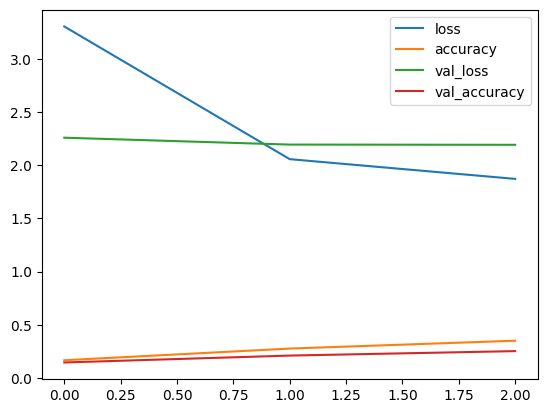

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot()

# this is the initial test results, currently i'm getting 35% accuracy and i'm still working on the improvements